MovieLens Dataset analysis

# Overview
- Reading the data
- Data analysis
- Clean gurbage data
- Data visualization

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import re
from wordcloud import WordCloud, STOPWORDS #used to generate world cloud
pd.set_option('mode.chained_assignment', None)

startTime = time.time()
movies = pd.read_csv("20M/movies.csv")
ratings = pd.read_csv("20M/ratings.csv")
links = pd.read_csv("20M/links.csv")
tags = pd.read_csv("20M/tags.csv")
# genomeScores = pd.read_csv("20M/genome-scores.csv")
# genomeTags = pd.read_csv("20M/genome-tags.csv")
print("It took %s seconds to load the data" % (time.time() - startTime))

It took 4.961429119110107 seconds to load the data


Exploring the data
As links only contains the url parts, we won't use it in our models

In [27]:
print(movies.shape)
print(ratings.shape)
print(links.shape)
print(tags.shape)

(27278, 3)
(20000263, 4)
(27278, 3)
(465564, 4)


Data cleaning

In [28]:
movies.isnull().any()

movieId    False
title      False
genres     False
dtype: bool

In [29]:
ratings.isnull().any()

userId       False
movieId      False
rating       False
timestamp    False
dtype: bool

In [30]:
tags.isnull().any()  # tag has some null value, so we will remove it from the dataset

userId       False
movieId      False
tag           True
timestamp    False
dtype: bool

In [31]:
tags = tags.dropna()
tags.isnull().any()

userId       False
movieId      False
tag          False
timestamp    False
dtype: bool

In [32]:
del ratings['timestamp']
del tags['timestamp']

In [33]:
movies['year'] = movies['title'].str.extract('\\(([0-9]+)\\)$', expand = False)
movies

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy,2007
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy,2002
27275,131258,The Pirates (2014),Adventure,2014
27276,131260,Rentun Ruusu (2001),(no genres listed),2001


In [34]:
movies.isnull().any()

movieId    False
title      False
genres     False
year        True
dtype: bool

In [35]:
movies = movies.dropna()
movies.isnull().any()

movieId    False
title      False
genres     False
year       False
dtype: bool

In [36]:
movies.loc[:, 'year'] = movies.loc[:, 'year'].astype(int)

In [37]:
movies = movies.sort_values(by = 'year')
movies

,movieId,title,genres,year
27015,129851,Dickson Greeting (1891),(no genres listed),1891
19213,95541,Blacksmith Scene (1893),(no genres listed),1893
19085,94951,Dickson Experimental Sound Film (1894),Musical,1894
17631,88674,Edison Kinetoscopic Record of a Sneeze (1894),Documentary,1894
25546,120869,Employees Leaving the Lumière Factory (1895),Documentary,1895
...,...,...,...,...
27004,129820,Spare Parts (2015),Children|Drama,2015
26049,124867,Justice League: Throne of Atlantis (2015),Action|Animation,2015
26701,128488,Wild Card (2015),Crime|Drama|Thriller,2015
27067,130069,Road Hard (2015),Comedy,2015


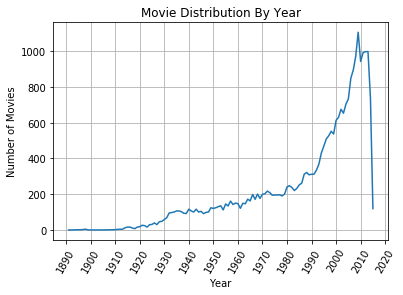

In [38]:
def movies_per_year():
    movie_year_count = movies.groupby('year').count()['movieId']
    plt.plot(movie_year_count)
    plt.xticks(np.arange(1890, 2015 + 10, 10), rotation=60)
    plt.grid()
    plt.ylabel("Number of Movies")
    plt.xlabel("Year")
    plt.title("Movie Distribution By Year")
    plt.show()
    

movies_per_year()

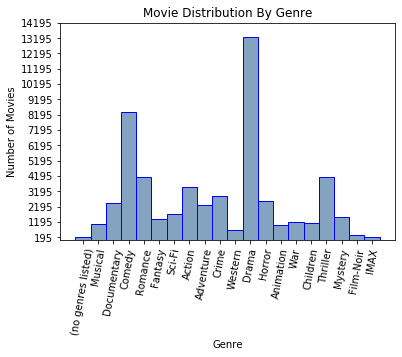

In [39]:
def movies_per_genre():
    moviesGenreCount = dict()
    for val in movies['genres'].values:
        for genre in val.strip().split('|'):
            if genre in moviesGenreCount:
                moviesGenreCount[genre] += 1
            else:
                moviesGenreCount[genre] = 1
    x, y = moviesGenreCount.keys(), moviesGenreCount.values()  # unpack a list of pairs into two tuples
    plt.bar(x, y, width=1.0, facecolor=(0.2, 0.4, 0.6, 0.6), edgecolor='blue')
    plt.xticks(rotation=80)
    plt.yticks(np.arange(min(y), max(y) + 1000, 1000))
    plt.ylabel("Number of Movies")
    plt.xlabel("Genre")
    plt.title("Movie Distribution By Genre")
    plt.show()
    
movies_per_genre()

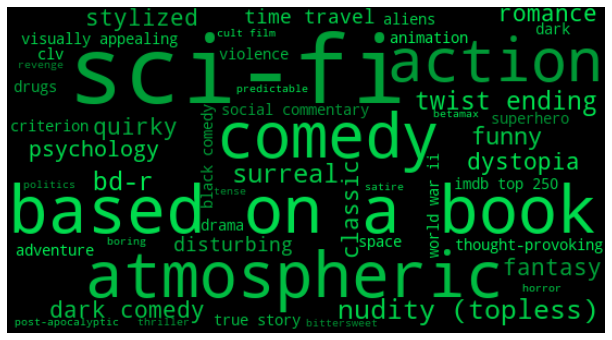

In [40]:
# define a function that counts the number of times each tag appear
def tags_data_parse():
    tag_count = dict()
    for tag in tags['tag']:
        tag = tag.lower()
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1
    tag_count = sorted(tag_count.items(), key = lambda x: x[1], reverse=True)
    return tag_count   


# Function that control the color of the words
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)


tag_count = dict(tags_data_parse()[0:50])
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='black', 
                      max_words=1628,relative_scaling=0.7,
                      color_func = random_color_func,
                      normalize_plurals=True)
wordcloud.generate_from_frequencies(tag_count)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()